# Imports and Utils

In [1]:
from keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
import time
import os
import glob

Using TensorFlow backend.
C:\Users\Mehdi\AppData\Local\conda\conda\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mehdi\AppData\Local\conda\conda\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mehdi\AppData\Local\conda\conda\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
def normalize(x):
    import numpy as np
    (654, 480, 640)
    normalized = (x-np.min(x))/(np.max(x)-np.min(x))
    normalized = np.clip(normalized, 0.001, 1, out=normalized)
    
    return normalized

In [3]:
from skimage.transform import resize

In [4]:
def load_images(image_files):
    loaded_images = []
    for file in image_files:
        x = np.asarray(Image.open(file), dtype=float)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

In [5]:
def evaluate(model, rgb, depth, crop, batch_size=6, minDepth=10, maxDepth = 1000, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predict(model, x/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0]) * 10.0
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predict(model, x[...,::-1,:]/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0]) * 10.0

        # Crop based on Eigen et al. crop
        true_y = true_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y = pred_y[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        pred_y_flip = pred_y_flip[:,crop[0]:crop[1]+1, crop[2]:crop[3]+1]
        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e

In [6]:
def evaluate_ue(model, rgb, depth, batch_size=6, minDepth=10, maxDepth = 1000, verbose=False):
    N = len(rgb)

    bs = batch_size

    predictions = []
    testSetDepths = []
    
    for i in range(N//bs):    
        x = rgb[(i)*bs:(i+1)*bs,:,:,:]
        
        # Compute results
        true_y = depth[(i)*bs:(i+1)*bs,:,:]
        pred_y = scale_up(2, predictue(model, x/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0])
        
        # Test time augmentation: mirror image estimate
        pred_y_flip = scale_up(2, predictue(model, x[...,::-1,:]/255, minDepth=minDepth, maxDepth=maxDepth, batch_size=bs)[:,:,:,0])

        
        # Compute errors per image in batch
        for j in range(len(true_y)):
            predictions.append(   (0.5 * pred_y[j]) + (0.5 * np.fliplr(pred_y_flip[j]))   )
            testSetDepths.append(   true_y[j]   )

    predictions = np.stack(predictions, axis=0)
    testSetDepths = np.stack(testSetDepths, axis=0)

    e = compute_errors(predictions, testSetDepths)

    if verbose:
        print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
        print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

    return e

In [7]:
def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

In [8]:
def scale_up(scale, images):
    from skimage.transform import resize
    scaled = []

    for i in range(len(images)):
        img = images[i]
        output_shape = (scale * img.shape[0], scale * img.shape[1])
        scaled.append(resize(img, output_shape, order=1, preserve_range=True, mode='reflect', anti_aliasing=True))

    return np.stack(scaled)

In [9]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return a1, a2, a3, abs_rel, rmse, log_10

In [14]:
def DepthNorm(x, maxDepth):
    return maxDepth / x

def predictue(model, images, minDepth=0, maxDepth=255, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return normalize(predictions)

# NYU Evaluation 

In [ ]:
#Loading Model into RAM
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
model = load_model('Models/Day_low.h5', custom_objects=custom_objects, compile=False)


In [ ]:
#Load NYU Test Data
from io import BytesIO
rgb = np.load('nyu_test/eigen_test_rgb.npy')
depth = np.load('nyu_test/eigen_test_depth.npy')
crop = np.load('nyu_test/eigen_test_crop.npy')


In [ ]:
#Normalizing each image inside the array individually
norm_depth = []

for a in depth:
    a = normalize(a)
    norm_depth.append(a)
    
norm_depth = np.array(norm_depth)

In [ ]:
e = evaluate_ue(model, rgb, norm_depth, batch_size=2, minDepth=0, maxDepth=255)
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('a1', 'a2', 'a3', 'rel', 'rms', 'log_10'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(e[0],e[1],e[2],e[3],e[4],e[5]))

In [ ]:
from skimage.transform import resize
count = 0
scoreaverage = []
for i, (img, label) in enumerate(zip(rgb, norm_depth)):
    
    pred = predictue(model, img/255).squeeze()
    scaled = resize(pred, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True)
    error = compute_errors(label,scaled)
    if error[0] > 0.5 : 
        count+=1
        scoreaverage.append(error)
        print(i, end='\r')
        
scoreaverage = np.array(scoreaverage)
print(scoreaverage.mean(0))
print(count)


In [ ]:
#Day High on NYU Filtered: 
#[0.59960347 0.84051659 0.93081892 0.28351495 0.12323485 0.10535632]

#Day HIgh on NYU Raw
#[0.36663455 0.60119291 0.758551   0.50440569 0.20139011 0.1937731 ]

#Day low on NYU Raw
#[0.37204183 0.60618285 0.76267943 0.50098358 0.2010055  0.19214524]

# Night_High on NYU Raw
# [0.34800212 0.57243906 0.72987421 0.51088394 0.21415319 0.20864302]


In [ ]:
i = 125
pred = predictue(model, rgb[i]/255, 10 ,1000)

print('rgb')
plt.imshow(rgb[i], cmap='magma_r')
#plt.colorbar()
plt.axis('off')
plt.show()
print('gt')

plt.imshow(norm_depth[i]*10, cmap='magma_r')
#plt.colorbar()
plt.axis('off')
plt.show()

plt.imshow(norm_depth[i]*10, cmap='tab20')
#plt.colorbar()
plt.axis('off')
plt.show()
print('prediction')
plt.imshow(pred[0,:,:,0], cmap='tab20')
#plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
#     Blue Night Low on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.2767,     0.5011,     0.7028,     0.3681,     0.1807,     0.2145

#     Blue Night High on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.2650,     0.4832,     0.6761,     0.3857,     0.1880,     0.2255

#     Blue Day Low on NYU
#      a1,         a2,         a3,        rel,        rms,     log_10
#     0.3387,     0.5825,     0.7688,     0.3317,     0.1736,     0.1886

#     Blue Day High on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.2664,     0.4836,     0.6753,     0.3871,     0.1884,     0.2256

#     Night_low on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.3112,     0.5483,     0.7388,     0.3635,     0.1759,     0.2020

#     Night_ High on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.3340,     0.5744,     0.7642,     0.3491,     0.1709,     0.1913

#     Day Low on NYU
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.3056,     0.5355,     0.7267,     0.3590,     0.1856,     0.2063

#     Day High on NYU 
#     a1,         a2,         a3,        rel,        rms,     log_10
#     0.3051,     0.5369,     0.7281,     0.3596,     0.1843,     0.2062


# (0.3051263721955128, 0.5369459985977564, 0.7281232421875, 0.35961992, 0.18432747, 0.20619658)

In [ ]:
# (0.0005970515970515971, 0.0016859643734643734, 0.006727579852579852, 0.80055004, 8.0510435, 0.7374447)

### DIODE DATASET DEPTH

In [ ]:
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
model = load_model('Models/Night_High.h5', custom_objects=custom_objects, compile=False)

In [ ]:
Diode = 'D:\\Desktop\\NYU_Test_depth\\git\\diode\\**\\*'      #scene_00021/scan_00188
imagelist = glob.glob(Diode+ '\*.png', recursive= True)

In [ ]:
average = []
for i, file in enumerate(imagelist):
    if file.endswith('.png'):
        img = np.asarray(Image.open(file))
        
        depth = np.load(file.replace('.png', '_depth.npy'))
        depthmask = np.load(file.replace('.png', '_depth_mask.npy'))
        depth[depthmask==0] = 1
        
        depthmask = resize(depthmask, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True)
        depth = resize(depth, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True).squeeze()
        
        depth[depthmask==0] = 1
        
        pred = predictue(model, img/255).squeeze()
        pred = np.clip(pred,0.1,pred.max())
        

        scaled = resize(pred, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True)
        
        s = np.median(depth)/np.median(scaled)
        
       
        scaled[depthmask==0] = 1
        scaled *= s
        error = compute_errors(depth,scaled)
        
#         plt.imshow(scaled, cmap='magma_r')
#         #plt.colorbar()
#         plt.axis('off')
#         plt.show()
        
        
#         plt.imshow(img)
#         plt.axis('off')
#         plt.show()
        
#         plt.imshow(depth, cmap='magma_r')
#         #plt.colorbar()
#         plt.axis('off')
#         plt.show()
        
#         plt.imshow(depth*10, cmap='tab20')
#         #plt.colorbar()
#         plt.axis('off')
#         plt.show()
        
        
        
        if error[0] > 0 : 
            print(i, error, end='\r') 
            average.append(error)
            
#         print(np.mean(average[0]),np.mean(average[1]),np.mean(average[2]),np.mean(average[3]),np.mean(average[4]))
#         print(file, error)        
average = np.array(average)
average.mean(0)

In [ ]:
average = np.array(average)
average.mean(0) #Day_High Filtered

In [ ]:
average = np.array(average)
average.mean(0) #Day_high Raw

In [ ]:
average = np.array(average)
average.mean(0) #NYU Raw

In [ ]:
average = np.array(average)
average.mean(0) #NYU Filtered


### UNREAL DEPTH

In [10]:
modelname = 'morse13K.h5'
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
uemodel = load_model(modelname, custom_objects=custom_objects, compile=False)


In [26]:
import glob 


source = 'E:/Dataset/Dataset/Ablation2/'
#source = 'test_data/same_domain/'
depthlist = glob.glob(source + 'Depth/*_final.png')
rgblist = glob.glob(source + 'real/*.jpg')
#rgblist = glob.glob(source + 'Same_domain_murky/*_final.png')

uedepth = load_images(depthlist)
uergb = load_images(rgblist)

In [27]:
uedepth = normalize(uedepth)
preds = predictue(uemodel, uergb/255)

In [35]:
plt.rcParams['figure.figsize'] = [16, 9]
print(len(rgblist))

7


E:/Dataset/Dataset/Ablation2/real\real3.jpg


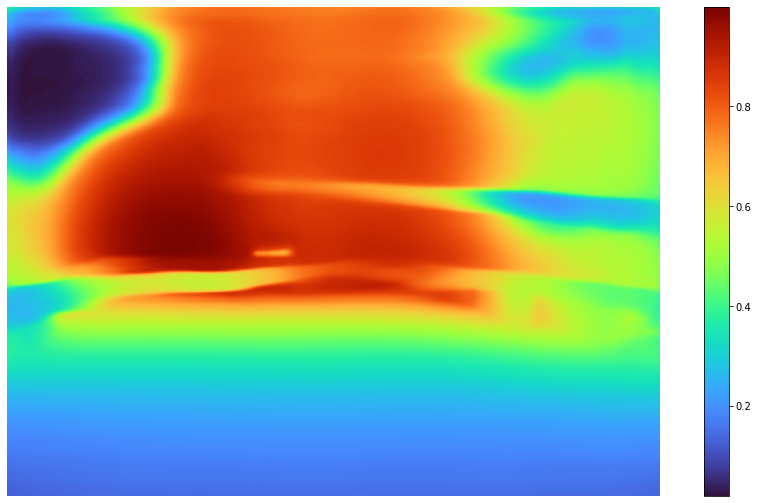

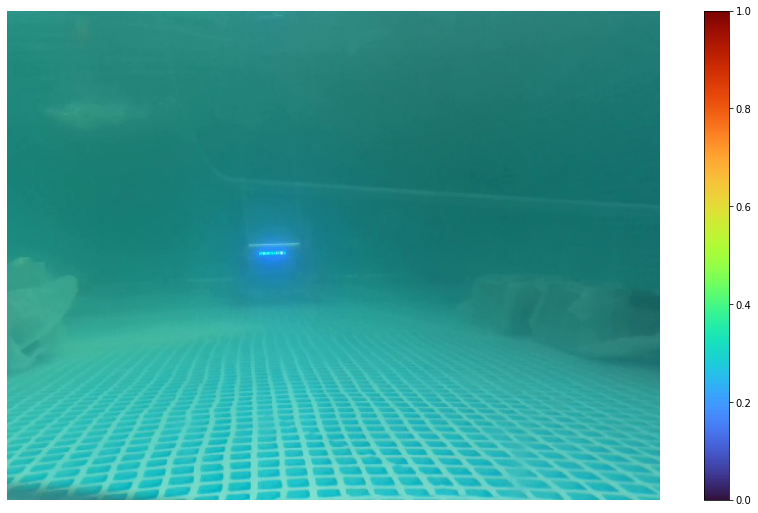

In [40]:
 i = 3
print(rgblist[i])
cemap = 'turbo'
plt.imshow(resize(preds[i,:,:,0], (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True), cmap=cemap)
#plt.imshow(preds[25,:,:,0], cmap='magma_r')
plt.colorbar()
plt.axis('off')
#plt.figure(figsize=(16,9))
plt.show()

# plt.imshow(uedepth[i,:,:], cmap=cemap)
# #plt.colorbar()
# plt.axis('off')
# #plt.figure(figsize=(16,9))
# plt.show()

plt.imshow(uergb[i,:,:]/255, cmap=cemap)
plt.colorbar()
plt.axis('off')
#plt.figure(figsize=(16,9))
plt.show()

In [98]:
count = 0
scoreaverage = []
for i, (img, label) in enumerate(zip(uergb, uedepth)):
    
    pred = predictue(uemodel, img/255).squeeze()
    scaled = resize(pred, (480,640), order=1, preserve_range=True, mode='reflect', anti_aliasing=True)
    error = compute_errors(label,scaled)
    if error[0] > 0 :  
        count+=1
        scoreaverage.append(error)
        print(i, end='\r')
        
scoreaverage = np.array(scoreaverage)
print(scoreaverage.mean(0))
print(count)


[0.3465968  0.60264714 0.64048074 0.4628038  0.14910791 0.38738796]
104
